In [15]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))


In [17]:
# load unique images from files
'''
Load images from their files. Each set of images should be kept in its own directory. Specify the path to this directory.
'''

import os 
from astropy.io import fits 
import numpy as np 
from sklearn.preprocessing import minmax_scale
PATH = "/home/roberttoyonaga/notebooks/roberttoyonaga/CMUDeepLensNRC/HSTLens/positive_cutout/"#etg/etg_raw_dec10/"#/good_quality/"#HSTLens_detections/"


ims = np.ones((len(os.listdir(PATH)), 1, 100, 100))
filenames = os.listdir(PATH)

count =0 
for filename in filenames: 
    try:
        pic = fits.open(PATH+filename)[0].data
#         pic = fits.open(PATH+str(filename)+".fits")[0].data#filename)[0].data
    except:
        pass
    
    if pic.shape != (100, 100):
        result = np.zeros((100,100))
        result[:pic.shape[1],:pic.shape[1]] = pic
        pic = result

    if np.isnan(pic).any()==True: #if any nan
        pic = np.nan_to_num(pic) #convert nan val to 0
        sky =3.*np.median(pic)- 2.*np.mean(pic)#calc sky now that there are no nan values
        pic[pic==0] = sky #convert 0 values to sky


    ims[count] = pic
    count+=1

print ims.shape


(7990, 1, 100, 100)


In [11]:
np.save('etg_unalt_167',ims)

((array([2.2000000e+03, 3.0225110e+06, 7.6658922e+07, 1.6086100e+05,
         2.7412000e+04, 1.0278000e+04, 5.1080000e+03, 3.1140000e+03,
         2.0110000e+03, 1.4150000e+03, 9.3300000e+02, 6.8200000e+02,
         5.4100000e+02, 4.4600000e+02, 3.3300000e+02, 2.6400000e+02,
         2.1500000e+02, 1.8500000e+02, 1.5700000e+02, 1.6200000e+02,
         1.5200000e+02, 1.1100000e+02, 1.0500000e+02, 1.0600000e+02,
         9.1000000e+01, 6.7000000e+01, 6.3000000e+01, 6.1000000e+01,
         6.0000000e+01, 1.4340000e+03]),
  array([-0.2 , -0.11, -0.02,  0.07,  0.16,  0.25,  0.34,  0.43,  0.52,
          0.61,  0.7 ,  0.79,  0.88,  0.97,  1.06,  1.15,  1.24,  1.33,
          1.42,  1.51,  1.6 ,  1.69,  1.78,  1.87,  1.96,  2.05,  2.14,
          2.23,  2.32,  2.41,  2.5 ]),
  <a list of 30 Patch objects>),
 -3.6946299076080322)

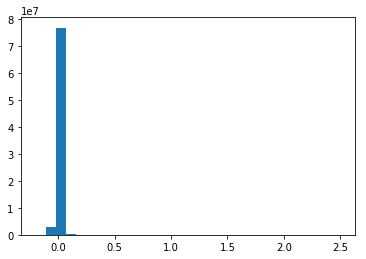

In [20]:
import matplotlib.pyplot as plt
clipped = np.clip(ims,-0.2,2.5)
plt.hist(clipped.reshape(-1),30),ims.min()+0.25

In [ ]:
s\

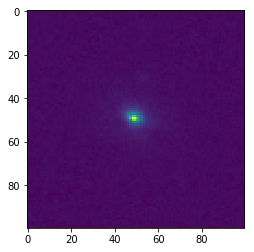

In [154]:
plt.imshow(clipped[66][0])

In [26]:
from sklearn.preprocessing import MinMaxScaler
import pickle

# scaler = MinMaxScaler()

# scaler.fit(clipped.reshape(-1,1))

# clipped_norm = scaler.transform(clipped.reshape(-1,1))
# clipped_norm = clipped_norm.reshape(clipped.shape)


# file_scaler = open('scaler_bin.obj', 'wb')
# pickle.dump(scaler, file_scaler)



file_scaler2 = open('scaler.obj', 'rb')
scaler_2 = pickle.load(file_scaler2)
clipped_norm_2 = scaler_2.transform(clipped.reshape(-1,1)).reshape(clipped.shape)

# clipped_norm.all()==clipped_norm_2.all()

# clipped_norm.shape
# plt.imshow(clipped_norm[118][0]), clipped_norm.min()

0.9999999999999999


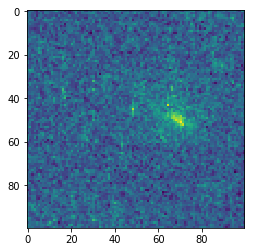

In [25]:
print clipped_norm_2.max()
plt.imshow(clipped_norm_2[3415][0])

In [10]:
#augmentation
'''
Apply data augmentation. For each incoming image, each transformation in the transform_list is performed. 
ie. if there are 5 incoming images and 10 transformations, there will be 50 images in the output array.
'''


import time
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.misc
import glob
from sklearn.model_selection import train_test_split
import random
import os 
import pandas as pd
from pandas import DataFrame as DF
from sklearn import preprocessing
from keras.models import load_model
import sys
from astropy.nddata.utils import Cutout2D 
from sklearn.preprocessing import minmax_scale
import numpy as np
import time

from keras.preprocessing.image import ImageDataGenerator
import scipy.ndimage


from astropy.convolution import convolve, Gaussian2DKernel
def augment(x):

    start= time.time()
   
    datagen = ImageDataGenerator(fill_mode = 'wrap')
    transform_dict1 = {'flip_horizontal':True, 'flip_vertical':False} 
    transform_dict2 = {'flip_horizontal':True, 'flip_vertical':False, 'theta': 90.0}
    transform_dict3 = {'flip_horizontal':False, 'flip_vertical':True}
    transform_dict4 = {'flip_horizontal':False, 'flip_vertical':True,'theta': 90.0}
    transform_dict5 = {'flip_horizontal':False, 'flip_vertical':False,'theta': 90.0}
    transform_dict6 = {'flip_horizontal':False, 'flip_vertical':False}
    transform_dict7 = {'flip_horizontal':True, 'flip_vertical':True,'theta': 90.0}
    transform_dict8 = {'flip_horizontal':True, 'flip_vertical':True}

    #reshape so colour channel is last (samples, width, height, colours)
    x_r = np.zeros((x.shape[0],x.shape[2],x.shape[2],x.shape[1]))


    for image in range(x.shape[0]):
        for color in range(x.shape[1]):
            x_r[image,:,:,color] = x[image,color,:,:]
 
    #apply transforms and add them to the dataset 
    x_aug = np.zeros((transforms*x_r.shape[0], x_r.shape[1], x_r.shape[2], x_r.shape[3]))
    for image in range(x_r.shape[0]):
        #rewrite the rotations as random for each new unique image
        transform_dict9 = {'flip_horizontal':False, 'flip_vertical':False,'theta':random.randint(1,89) }
        transform_dict10 = {'flip_horizontal':True, 'flip_vertical':True,'theta': random.randint(1,89)}
        transform_dict11 = {'flip_horizontal':True, 'flip_vertical':False,'theta': random.randint(1,89)}
        transform_dict12 = {'flip_horizontal':False, 'flip_vertical':True,'theta': random.randint(1,89)}
        transform_dict13 = {'flip_horizontal':False, 'flip_vertical':False,'theta': -random.randint(1,89)}
        transform_dict14 = {'flip_horizontal':True, 'flip_vertical':True,'theta': -random.randint(1,89)}
        transform_dict15 = {'flip_horizontal':True, 'flip_vertical':False,'theta': -random.randint(1,89)}
        transform_dict16 = {'flip_horizontal':False, 'flip_vertical':True,'theta': -random.randint(1,89)}
        transform_dict17 = {'flip_horizontal':False, 'flip_vertical':False,'theta':random.randint(1,89) }
        transform_dict18 = {'flip_horizontal':True, 'flip_vertical':True,'theta': random.randint(1,89)}
        transform_dict19 = {'flip_horizontal':True, 'flip_vertical':False,'theta': random.randint(1,89)}
        transform_dict20 = {'flip_horizontal':False, 'flip_vertical':True,'theta': random.randint(1,89)}
        transform_dict21 = {'flip_horizontal':False, 'flip_vertical':False,'theta': -random.randint(1,89)}
        transform_dict22 = {'flip_horizontal':True, 'flip_vertical':True,'theta': -random.randint(1,89)}
        transform_dict23 = {'flip_horizontal':True, 'flip_vertical':False,'theta': -random.randint(1,89)}
        transform_dict24 = {'flip_horizontal':False, 'flip_vertical':True,'theta': -random.randint(1,89)}
        transform_dict25 = {'flip_horizontal':False, 'flip_vertical':False,'theta':random.randint(1,89) }
        transform_dict26 = {'flip_horizontal':True, 'flip_vertical':True,'theta': random.randint(1,89)}
        transform_dict27 = {'flip_horizontal':True, 'flip_vertical':False,'theta': random.randint(1,89)}
        transform_dict28 = {'flip_horizontal':False, 'flip_vertical':True,'theta': random.randint(1,89)}
        transform_dict29 = {'flip_horizontal':False, 'flip_vertical':False,'theta': -random.randint(1,89)}
        transform_dict30 = {'flip_horizontal':True, 'flip_vertical':True,'theta': -random.randint(1,89)}
        transform_dict31 = {'flip_horizontal':True, 'flip_vertical':False,'theta': -random.randint(1,89)}
        transform_dict32 = {'flip_horizontal':False, 'flip_vertical':True,'theta': -random.randint(1,89)}
        transform_dict33 = {'flip_horizontal':False, 'flip_vertical':False,'theta':random.randint(1,89) }
        transform_dict34 = {'flip_horizontal':True, 'flip_vertical':True,'theta': random.randint(1,89)}
        transform_dict35 = {'flip_horizontal':True, 'flip_vertical':False,'theta': random.randint(1,89)}
        transform_dict36 = {'flip_horizontal':False, 'flip_vertical':True,'theta': random.randint(1,89)}
        transform_dict37 = {'flip_horizontal':False, 'flip_vertical':False,'theta': -random.randint(1,89)}
        transform_dict38 = {'flip_horizontal':True, 'flip_vertical':True,'theta': -random.randint(1,89)}
        transform_dict39 = {'flip_horizontal':True, 'flip_vertical':False,'theta': -random.randint(1,89)}
        transform_dict40 = {'flip_horizontal':False, 'flip_vertical':True,'theta': -random.randint(1,89)}
        
#         transform_list= [ transform_dict1,transform_dict2, transform_dict3,transform_dict4,transform_dict5,
#                 transform_dict6, transform_dict7 , transform_dict8, transform_dict9, transform_dict10,
#                 transform_dict11,transform_dict12, transform_dict13, transform_dict14, transform_dict15,
#                 transform_dict16,transform_dict17,transform_dict18,transform_dict19,transform_dict20,transform_dict21,transform_dict22,
#                         transform_dict23,transform_dict24,transform_dict25,transform_dict26,transform_dict27,transform_dict28,transform_dict29,transform_dict30,
#                         transform_dict31,transform_dict32,transform_dict33,transform_dict34,transform_dict35,transform_dict36,transform_dict37,transform_dict38,
#                         transform_dict39,transform_dict40]
        transform_list= [ transform_dict1,transform_dict2,transform_dict23,transform_dict33,transform_dict4,
                         transform_dict24,transform_dict25,transform_dict26,transform_dict27,transform_dict40,
                         transform_dict28,transform_dict3,transform_dict4,transform_dict8,transform_dict9]        
        
        for transform in range(len(transform_list)):
            x_aug[image + x_r.shape[0]*transform] = datagen.apply_transform(x_r[image], transform_list[transform])

    
    #reshape so colour channel is axis=1 (samples,colours, width, height)
    x_aug_cf = np.zeros((x_aug.shape[0],x_aug.shape[3],x_aug.shape[2],x_aug.shape[2]))
    
    for image in range(x_aug.shape[0]):
        for color in range(x_aug.shape[3]):
            x_aug_cf[image,color,:,:] = x_aug[image,:,:,color]

    return x_aug_cf

# reals = np.load('real_clean_norm_paper.npy')
transforms=15
ims_aug = augment(ims)
print ims_aug.shape

(6375, 1, 100, 100)


In [14]:

np.save('h5/hand_selected/pos_d_aug_dec12',ims_aug)

In [15]:
ims = np.load('h5/hand_selected/pos_d_aug_dec12.npy')
ims.shape

(6375, 1, 100, 100)

In [9]:
# save augmented images
for i in range(ims_aug.shape[0]):
    fits.writeto('/home/roberttoyonaga/notebooks/roberttoyonaga/CMUDeepLensNRC/HSTLens/etg/etg_neg_no-norm_aug_dec10/etg_neg_norm_aug_dec10_' 
                 + str(i)+'.fits', ims_aug[i][0], overwrite =True) 


In [11]:
# np.save('etg_neg_aug_scaled_1200',ims_aug)

In [53]:
# MERGE AND SAVE catalog images

'''
This merges and normalizes simulated lesness with real images. Specify the paths to files that you want to merge(OUT_PATH). You can specify '1' for images that
come from the Grazian catalog (more noisy) and 2 for images that were found to be false positives from detection. The only difference will be that the 
catalog images are combined with a higher lens:real_image ratio. Save images to a folder when done (MERGED_PATH).
'''
import pickle

import os
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from astropy.convolution import convolve, Gaussian2DKernel
import random


hm_lenses = int(input("How many lenses do you want to merge with associated cutouts? "))
catalog = int(input("1 = catalog, 2 = false positives from detections "))


file_scaler2 = open('scaler.obj', 'r')
scaler_2 = pickle.load(file_scaler2)


if catalog ==1:
    pass
else:
    LENSES_PATH ="/home/roberttoyonaga/notebooks/roberttoyonaga/CMUDeepLensNRC/HSTLens/lenses_h2/l_"#'/home/roberttoyonaga/notebooks/roberttoyonaga/CMUDeepLensNRC/HSTLens/old_datasets/large_lenses/l_'
    #
    #"/home/roberttoyonaga/notebooks/roberttoyonaga/CMUDeepLensNRC/HSTLens/old_datasets/large_lenses/l_"
    OUT_PATH = "/home/roberttoyonaga/notebooks/roberttoyonaga/CMUDeepLensNRC/HSTLens/etg/etg_raw_dec10/"
    MERGED_PATH = "/home/roberttoyonaga/notebooks/roberttoyonaga/CMUDeepLensNRC/HSTLens/etg/etg_merged_wild_lenses_dec10/etg_ll2_"


#calculate standard deviation from full width half maximum and create gaussian kernel
FWHM = 0.986 #dealing in pixels
sigma = FWHM  / ( 2*np.sqrt(2*np.log(2)) )
gauss_kernel = Gaussian2DKernel(sigma)

def normalize( all_cutouts, all_lenses, hm_lenses): #only for 1 color channel. Scale both (0,1)
    for lens_number in range(hm_lenses):
        try:
            max_val = all_cutouts[lens_number][0][35:65,40:60].max()
            
            if catalog==1:

                alpha = [max_val*float(random.randint(8,20))/100.,
                         max_val*float(random.randint(8,20))/100.,
                         max_val*float(random.randint(8,20))/100.,
                         max_val*float(random.randint(8,20))/100.]  
            else:    
                alpha = [max_val*float(random.randint(80,220))/10000.,
                         max_val*float(random.randint(80,220))/10000.,
                         max_val*float(random.randint(80,220))/10000.,
                         max_val*float(random.randint(80,220))/10000.]  


            for i in range(len(alpha)): 
                l = all_lenses[lens_number + hm_lenses*i][0]
                tmp_lens = l.reshape(-1,)                                        
                tmp_lens = minmax_scale(tmp_lens, feature_range = (0, 1))*alpha[i]     
                all_lenses[lens_number + hm_lenses*i][0] = tmp_lens.reshape(all_lenses.shape[2],all_lenses.shape[2])
                
                summed=np.add(all_cutouts[lens_number + hm_lenses*i][0], all_lenses[lens_number + hm_lenses*i][0])
#                 tmp_image = scaler_2.transform(np.clip(summed.reshape(-1,1), -0.2,2.5))
#                 summed = tmp_image.reshape(summed.shape[0],summed.shape[1])
                
                save_image(lens_number + hm_lenses*i, summed)
        except:
            print ("unable to noramlize and add new")
            
        

def load_images(sample_num): 
    if catalog==1:
        cutout = fits.open(OUT_PATH+ str(sample_num)+".fits")[0].data 
    else:
        cutout = fits.open(OUT_PATH+ filenames[sample_num])[0].data 
    
    lens = fits.open(LENSES_PATH+str(sample_num+1500)+".fits")[0].data 
    lens = convolve(lens, gauss_kernel) #convolve with PSF

    cutout = cutout.reshape(1,cutout.shape[0],cutout.shape[1])
    lens = lens.reshape(1,lens.shape[0],lens.shape[1])
    return cutout, lens

def save_image(image_number, merged):
    fits.writeto(MERGED_PATH + str(image_number)+'.fits', merged, overwrite =True) 
    
def verify(num):
    os.system('sextractor  /data/notebooks/roberttoyonaga/CMUDeepLensNRC/HSTLens/positive_cutout/o_'+str(num)+'.fits -c default1.se -CATALOG_NAME my_catalog.cat')
    tp_se =np.loadtxt('my_catalog.cat')
    
    #corner cases
    if len((tp_se))==0: tp_se=np.zeros((1,15))#specific to when you have 15 params
    if len(np.shape(tp_se))==1: tp_se=np.reshape(tp_se,(1,15))

    for k1 in range(len(tp_se)):
        if (tp_se[k1,0]<67) & (tp_se[k1,0]>37) & (tp_se[k1,1]<67) & (tp_se[k1,1]>37):
            return True
    return False

all_cutouts = np.zeros((hm_lenses*4,1,100,100))
all_lenses = np.zeros((hm_lenses*4,1,100,100))


filenames = os.listdir(OUT_PATH)

bad_images = [] #keep track of and remove bad images later
for image in range(hm_lenses):
    try:
#         verify image has a central source
#         if verify(image)==False:
#             for i in range(4):
#                 bad_images.append(image+hm_lenses*i)
#             print("no central source: " +str(image))
#             continue
            
        #load each image into 4 spots in each respective array
        for weight in range(4):
            all_cutouts[image + hm_lenses*weight], all_lenses[image+hm_lenses*weight] = load_images(image)
    except:
        for i in range(4):
            bad_images.append(image+hm_lenses*i)
        print("couldnt find image: " +str(image))
    
hm_lenses -=len(bad_images)/4
all_cutouts = np.delete(all_cutouts,bad_images, axis=0)
all_lenses = np.delete(all_lenses,bad_images, axis=0)
    
print("images loaded") 
        
normalize(all_cutouts, all_lenses, hm_lenses) #must call this first before modifying all_cutouts
print("images normalized and summed")   




How many lenses do you want to merge with associated cutouts? 167
1 = catalog, 2 = false positives from detections 2
images loaded
images normalized and summed


In [26]:
# load images from files
'''
Load images from their files. Each set of images should be kept in its own directory. Specify the path to this directory.
'''

import os 
from astropy.io import fits 
import numpy as np 
from sklearn.preprocessing import minmax_scale
PATH ="/home/roberttoyonaga/notebooks/roberttoyonaga/CMUDeepLensNRC/HSTLens/faure_100x100_no-norm/" #/h5/hand_selected/pos_d/"#/good_quality/"#HSTLens_detections/"


ims = np.ones((len(os.listdir(PATH)), 1, 100, 100))
filenames = os.listdir(PATH)

count =0 
for filename in filenames: 
    try:
        pic = fits.open(PATH+filename)[0].data
#         pic = fits.open(PATH+str(filename)+".fits")[0].data#filename)[0].data
    except:
        pass
    
        if pic.shape != (100, 100):
            result = np.zeros((100,100))
            result[:pic.shape[1],:pic.shape[1]] = pic
            pic = result
            
        if np.isnan(pic).any()==True: #if any nan
            pic = np.nan_to_num(pic) #convert nan val to 0
            sky =3.*np.median(pic)- 2.*np.mean(pic)#calc sky now th


    ims[count] = pic
    count+=1

print ims.shape,ims.min(), ims.max()


ValueError: could not broadcast input array from shape (91,100) into shape (1,100,100)

In [145]:
ims2.min(), scaler_2.transform((clipped*1.2).reshape(-1,1)).max(), ims2.shape

(-0.02090705469128387, 1.191499405517114, (10688, 1, 100, 100))

In [15]:
pos_etg = np.concatenate((ims,ims2))
np.random.shuffle(pos_etg)
np.save('pos_etg_dec10',pos_etg)
a= np.load('pos_etg_dec10.npy')
a.shape

(21376, 1, 100, 100)

In [3]:
668./4

167.0

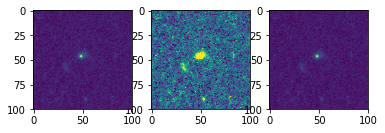

curr num 5002 next=1, exit=00


In [16]:
##### quickly view some images
'''
This cell allows for quick viewing of training examples that you've created. 
You can uncomment lines to plot the original images besided the finished product.
'''
from astropy.visualization import (ZScaleInterval, ImageNormalize)

import matplotlib.pyplot as plt
from IPython import display
import os
BRIGHT_PATH = "h5/hand_selected/etg_pos_b/etg_pos_b6_"
DIM_PATH = "h5/hand_selected/etg_pos_d/etg_pos_d6_"

ims1 = ims_aug
# ims2 = all_cutouts
# ims3 =new 
sp=int(input("start position"))
for i in range(len(ims1)):
    exit=False
    


    while(1):

        display.clear_output(wait=True)

        fig = plt.figure()
        ax1 = fig.add_subplot(1,3,2)
        norm = ImageNormalize(ims1[i+sp][0], interval = ZScaleInterval())
        ax1.imshow(ims1[i+sp][0],norm=norm)

        ax2 = fig.add_subplot(1,3,1)
        ax2.imshow(np.log10(ims1[i+sp][0]+1))

        ax3 = fig.add_subplot(1,3,3)
        ax3.imshow((ims1[i+sp][0]))
        plt.pause(0.01)
        
        ans = int(input("curr num "+str(i+sp)+" next=1, exit=0"))
#         plt.imshow((ims1[i+sp][0]))#,cmap='gray') 
#         norm = ImageNormalize(ims1[i+sp][0], interval = ZScaleInterval())
#         plt.imshow(ims1[i+sp][0],norm=norm)

        
        
        
        
        if ans ==5:
            break
        if ans==0:
            exit=True
            break
        if ans==7:
            fits.writeto(BRIGHT_PATH+str(sp)+"_" +str(i)+'.fits',ims1[i+sp][0], header=None, overwrite =True)
            break
        if ans==9:
            fits.writeto(DIM_PATH+str(sp)+"_" +str(i)+'.fits',ims1[i+sp][0], header=None, overwrite =True)
            break
    if exit==True:
        break
 #     plt.imshow(np.log10(ims1[i+sp][0]),cmap='gray') 
#     fig = plt.figure()
#     ax1 = fig.add_subplot(1,3,2)
#     ax1.set_title("Original")
#     ax1.imshow(ims2[i+sp][0],cmap='gray')
#     ax2 = fig.add_subplot(1,3,1)
#     ax2.set_title("Old")
#     ax2.imshow(ims1[i+sp][0],cmap='gray')
#     ax3 = fig.add_subplot(1,3,3)
#     ax3.set_title("New")
#     ax3.imshow(ims3[i+sp][0],cmap='gray')       

# 